In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet
# from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from utils_data_structures import col_prefixes

In [2]:
grouped_df = pd.read_csv('sorare_data/large_grouped_sorare_data.csv')

grouped_df = grouped_df.fillna(0.0)

# grouped_df = pd.get_dummies(grouped_df, columns=['Current_Club'])

print(grouped_df['So_5_Scores_9'].isna().sum())

0


In [3]:
epl_defenders_df = grouped_df[grouped_df['Position'] == 'Defender']
epl_defenders_df = epl_defenders_df.drop(columns=['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club'])


In [4]:
epl_defenders_df.dtypes.value_counts()

float64    309
int64        4
Name: count, dtype: int64

In [5]:
# Create X and y and split into training and testing sets
target_column = 'So_5_Scores_9'
columns_to_drop = [f'{col}_9' for col in col_prefixes]

X = epl_defenders_df.drop(columns=columns_to_drop)
y = epl_defenders_df[target_column]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
y_pred_xgb_clipped = np.clip(y_pred_xgb, 0, 100)
mse = mean_squared_error(y_test, y_pred_xgb_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 18.236504245822264


In [8]:
# Initialize the LightGBM regressor
lgbm_model = lgb.LGBMRegressor(
    boosting_type='gbdt',  # Gradient boosting decision tree
    n_estimators=400,      # Number of boosting rounds (trees)
    learning_rate=0.01,     # Step size shrinkage
    max_depth=10,          # Unlimited depth of trees (-1 means no limit)
    random_state=42,        # For reproducibility
)
# 

# Train the model
lgbm_model.fit(X_train, y_train)
# Make predictions
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate
y_pred_lgmb_clipped = np.clip(y_pred_lgbm, 0, 100)
mse = mean_squared_error(y_test, y_pred_lgmb_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9770
[LightGBM] [Info] Number of data points in the train set: 3992, number of used features: 211
[LightGBM] [Info] Start training from score 17.612943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
RMSE: 17.621148099255755


In [9]:

# Initialize ElasticNet
elastic_model = ElasticNet(alpha=0.05, l1_ratio=0.9, random_state=42)

# Train the model
elastic_model.fit(X_train, y_train)

# Make predictions
y_pred_en = elastic_model.predict(X_test)

# Evaluate
y_pred_en_clipped = np.clip(y_pred_en, 0, 100)
mse = mean_squared_error(y_test, y_pred_en_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 17.65639189401174


c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.067e+05, tolerance: 2.496e+02
  model = cd_fast.enet_coordinate_descent(


In [10]:
with open('sorare_models/defenders_xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)
    print("XGB Model saved successfully!")
with open('sorare_models/defenders_lgbm_model.pkl', 'wb') as file:
    pickle.dump(lgbm_model, file)
    print("LGBM Model saved successfully!")

with open('sorare_models/defenders_elastic_model.pkl', 'wb') as file:
    pickle.dump(elastic_model, file)
    print("Elastic Model saved successfully!")

print("Models saved successfully!")

XGB Model saved successfully!
LGBM Model saved successfully!
Elastic Model saved successfully!
Models saved successfully!


In [11]:
y_test_df = pd.DataFrame(y_test)
y_test_df['XBG_Predictions'] = y_pred_xgb_clipped
y_test_df['LGBM_Predictions'] = y_pred_lgmb_clipped
y_test_df['EN_Predictions'] = y_pred_en_clipped
y_test_df

,So_5_Scores_9,XBG_Predictions,LGBM_Predictions,EN_Predictions
14665,89.04000,39.004868,43.897229,52.399224
7141,49.50000,37.873955,39.820335,47.273513
11335,45.68342,52.401001,51.028973,53.932988
3780,0.00000,0.238649,1.703972,2.413037
9300,0.00000,0.000000,0.883869,1.232795
...,...,...,...,...
10871,48.62000,52.287380,49.033959,49.581031
14091,29.60000,1.215114,2.697874,5.160400
12457,32.38000,33.645992,29.678843,37.725126
15310,0.00000,0.000000,0.883869,0.859579


In [12]:
y_test_df['Average_Prediction'] = (y_test_df['XBG_Predictions'] + y_test_df['LGBM_Predictions'] + y_test_df['EN_Predictions']) / 3
y_test_df = y_test_df[(y_test_df['So_5_Scores_9'] <= 55) & (y_test_df['So_5_Scores_9'] >= 5)]
y_test_df
pd.set_option('display.max_columns', None)
epl_defenders_df.iloc[[4544]]

,So_5_Scores_0,So_5_Scores_1,So_5_Scores_2,So_5_Scores_3,So_5_Scores_4,So_5_Scores_5,So_5_Scores_6,So_5_Scores_7,So_5_Scores_8,So_5_Scores_9,accuratePass_0,accuratePass_1,accuratePass_2,accuratePass_3,accuratePass_4,accuratePass_5,accuratePass_6,accuratePass_7,accuratePass_8,accuratePass_9,assistPenaltyWon_0,assistPenaltyWon_1,assistPenaltyWon_2,assistPenaltyWon_3,assistPenaltyWon_4,assistPenaltyWon_5,assistPenaltyWon_6,assistPenaltyWon_7,assistPenaltyWon_8,assistPenaltyWon_9,bigChanceCreated_0,bigChanceCreated_1,bigChanceCreated_2,bigChanceCreated_3,bigChanceCreated_4,bigChanceCreated_5,bigChanceCreated_6,bigChanceCreated_7,bigChanceCreated_8,bigChanceCreated_9,cleanSheet_0,cleanSheet60_0,cleanSheet_1,cleanSheet60_1,cleanSheet_2,cleanSheet60_2,cleanSheet_3,cleanSheet60_3,cleanSheet_4,cleanSheet60_4,cleanSheet_5,cleanSheet60_5,cleanSheet_6,cleanSheet60_6,cleanSheet_7,cleanSheet60_7,cleanSheet_8,cleanSheet60_8,cleanSheet_9,cleanSheet60_9,crossAccuracy_0,crossAccuracy_1,crossAccuracy_2,crossAccuracy_3,crossAccuracy_4,crossAccuracy_5,crossAccuracy_6,crossAccuracy_7,crossAccuracy_8,crossAccuracy_9,duelWon_0,duelWon_1,duelWon_2,duelWon_3,duelWon_4,duelWon_5,duelWon_6,duelWon_7,duelWon_8,duelWon_9,effectiveClearance_0,effectiveClearance_1,effectiveClearance_2,effectiveClearance_3,effectiveClearance_4,effectiveClearance_5,effectiveClearance_6,effectiveClearance_7,effectiveClearance_8,effectiveClearance_9,errorLeadToGoal_0,errorLeadToGoal_1,errorLeadToGoal_2,errorLeadToGoal_3,errorLeadToGoal_4,errorLeadToGoal_5,errorLeadToGoal_6,errorLeadToGoal_7,errorLeadToGoal_8,errorLeadToGoal_9,fouls_0,fouls_1,fouls_2,fouls_3,fouls_4,fouls_5,fouls_6,fouls_7,fouls_8,fouls_9,gameStarted_0,gameStarted_1,gameStarted_2,gameStarted_3,gameStarted_4,gameStarted_5,gameStarted_6,gameStarted_7,gameStarted_8,gameStarted_9,goalAssist_0,goalAssist_1,goalAssist_2,goalAssist_3,goalAssist_4,goalAssist_5,goalAssist_6,goalAssist_7,goalAssist_8,goalAssist_9,goals_0,goals_1,goals_2,goals_3,goals_4,goals_5,goals_6,goals_7,goals_8,goals_9,interceptionWon_0,interceptionWon_1,interceptionWon_2,interceptionWon_3,interceptionWon_4,interceptionWon_5,interceptionWon_6,interceptionWon_7,interceptionWon_8,interceptionWon_9,lastManTackle_0,lastManTackle_1,lastManTackle_2,lastManTackle_3,lastManTackle_4,lastManTackle_5,lastManTackle_6,lastManTackle_7,lastManTackle_8,lastManTackle_9,minsPlayed_0,minsPlayed_1,minsPlayed_2,minsPlayed_3,minsPlayed_4,minsPlayed_5,minsPlayed_6,minsPlayed_7,minsPlayed_8,minsPlayed_9,ownGoals_0,ownGoals_1,ownGoals_2,ownGoals_3,ownGoals_4,ownGoals_5,ownGoals_6,ownGoals_7,ownGoals_8,ownGoals_9,passAccuracy_0,passAccuracy_1,passAccuracy_2,passAccuracy_3,passAccuracy_4,passAccuracy_5,passAccuracy_6,passAccuracy_7,passAccuracy_8,passAccuracy_9,penaltiesSaved_0,penaltiesSaved_1,penaltiesSaved_2,penaltiesSaved_3,penaltiesSaved_4,penaltiesSaved_5,penaltiesSaved_6,penaltiesSaved_7,penaltiesSaved_8,penaltiesSaved_9,penaltyConceded_0,penaltyConceded_1,penaltyConceded_2,penaltyConceded_3,penaltyConceded_4,penaltyConceded_5,penaltyConceded_6,penaltyConceded_7,penaltyConceded_8,penaltyConceded_9,penaltyKickMissed_0,penaltyKickMissed_1,penaltyKickMissed_2,penaltyKickMissed_3,penaltyKickMissed_4,penaltyKickMissed_5,penaltyKickMissed_6,penaltyKickMissed_7,penaltyKickMissed_8,penaltyKickMissed_9,penaltySave_0,penaltySave_1,penaltySave_2,penaltySave_3,penaltySave_4,penaltySave_5,penaltySave_6,penaltySave_7,penaltySave_8,penaltySave_9,redCard_0,redCard_1,redCard_2,redCard_3,redCard_4,redCard_5,redCard_6,redCard_7,redCard_8,redCard_9,saves_0,saves_1,saves_2,saves_3,saves_4,saves_5,saves_6,saves_7,saves_8,saves_9,shotAccuracy_0,shotAccuracy_1,shotAccuracy_2,shotAccuracy_3,shotAccuracy_4,shotAccuracy_5,shotAccuracy_6,shotAccuracy_7,shotAccuracy_8,shotAccuracy_9,totalClearance_0,totalClearance_1,totalClearance_2,totalClearance_3,totalClearance_4,totalClearance_5,totalClearance_6,totalClearance_7,totalClearance_8,totalClearance_9,totalPass_0,totalPass_1,totalPass_2,totalPass_3,t

In [13]:
y_true = y_test_df['So_5_Scores_9'].to_numpy()
y_pred = y_test_df['Average_Prediction'].to_numpy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmse

16.352254787026375

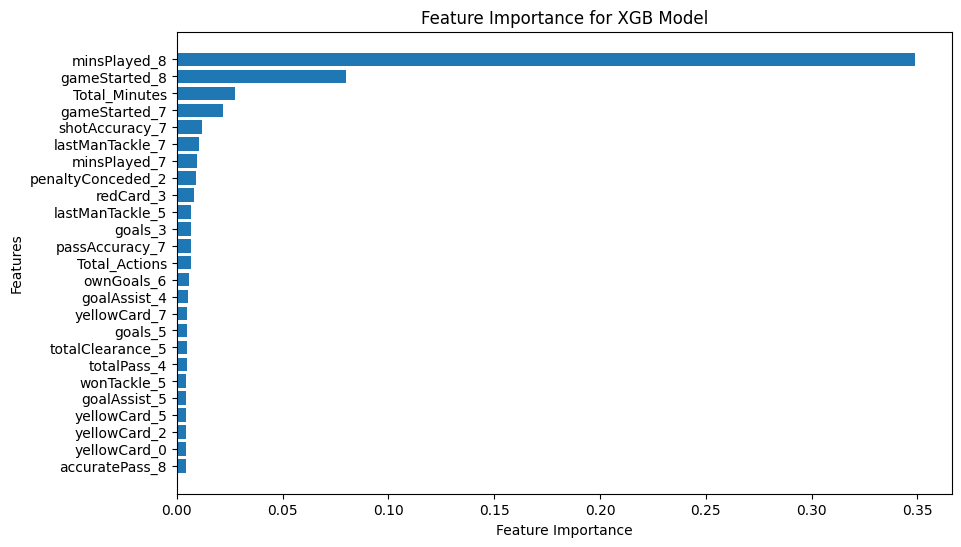

In [14]:

# Get feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

top_n = 25  # Number of top features to show
top_features = feature_importance_df.nlargest(top_n, 'Importance')

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for XGB Model')
plt.gca().invert_yaxis()
plt.show()

In [15]:
epl_teams = pd.read_csv('sorare_data/large_cleaned_sorare_data.csv')

epl_teams = epl_teams.fillna(0.0)

epl_defenders_df = epl_teams[epl_teams['Position'] == 'Defender']

epl_defenders_df = epl_defenders_df.reset_index(drop=True)

In [16]:
drop_columns = columns=['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club']

columns_to_drop = [f'{col}_9' for col in col_prefixes]
columns_to_drop.extend(drop_columns)

target_column = 'So_5_Scores_9'

X_test_defenders = epl_defenders_df.drop(columns=columns_to_drop)
y_test_defenders = epl_defenders_df[target_column]

In [17]:
with open('sorare_models/defenders_xgb_model.pkl', 'rb') as file:
    defenders_xgb_model_loaded = pickle.load(file)
    print("XGB Model loaded successfully!")
with open('sorare_models/defenders_lgbm_model.pkl', 'rb') as file:
    defenders_lgbm_model_loaded = pickle.load(file)
    print("LGBM Model loaded successfully!")
with open('sorare_models/defenders_elastic_model.pkl', 'rb') as file:
    defenders_elastic_model_loaded = pickle.load(file)
    print("Elastic Model loaded successfully!")

XGB Model loaded successfully!
LGBM Model loaded successfully!
Elastic Model loaded successfully!


In [18]:
xgb_predictions = defenders_xgb_model_loaded.predict(X_test_defenders)
lgbm_predictions = defenders_lgbm_model_loaded.predict(X_test_defenders)
elastic_predictions = defenders_elastic_model_loaded.predict(X_test_defenders)

xgb_predictions = np.clip(xgb_predictions, 0, 100)
lgbm_predictions = np.clip(lgbm_predictions, 0, 100)
elastic_predictions = np.clip(elastic_predictions, 0, 100)

y_test_defenders_df = pd.DataFrame(y_test_defenders)

epl_defenders_df['sorare_xgb_predictions'] = pd.Series(xgb_predictions)
epl_defenders_df['sorare_lgbm_predictions'] = pd.Series(lgbm_predictions)
epl_defenders_df['sorare_elastic_predictions'] = pd.Series(elastic_predictions)

epl_defenders_df['sorare_predictions'] = epl_defenders_df[['sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions']].mean(axis=1)

epl_defenders_df[['So_5_Scores_9','sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions']].head(3)

,So_5_Scores_9,sorare_xgb_predictions,sorare_lgbm_predictions,sorare_elastic_predictions
0,0.00,8.526336,28.886359,40.372045
1,0.00,1.323632,1.881206,2.887476
2,34.16,36.960781,42.448514,45.285430


In [19]:
y_true = epl_defenders_df['So_5_Scores_9'].to_numpy() 
y_pred = epl_defenders_df['sorare_predictions'].to_numpy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmse

15.017927213688848

In [20]:
saved_defenders_df = epl_defenders_df[['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club','So_5_Scores_9','sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions', 'sorare_predictions']]
saved_defenders_df.to_csv('sorare_data/predictions/sorare_defenders_predictions.csv', index=False)